# EE461P Term Project: Predicting Hotel Bookings on Expedia

### Group Members
1. Zander Tedjo (zbt86)
2. Alex Li
3. Shiv Lalapet
4. James Lu

## Preprocessing

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

#https://www.kaggle.com/c/expedia-hotel-recommendations


In [4]:
import os
#Current cell and next two used to access my google drive

cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in '/content': ['.config', 'gdrive', 'sample_data']


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
%cd /content/gdrive/My\ Drive
!pwd
cdir = os.getcwd()
fileList = os.listdir(cdir)
print("Files in %r: %s" % (cdir, fileList))
os.chdir("DSP/Final Project")
os.listdir()

/content/gdrive/My Drive
/content/gdrive/My Drive
Files in '/content/gdrive/My Drive': ['Lab 03 - Hardware Interfacing LED Switch.gdoc', 'Copy of Lab 06 - Piano DAC.gdoc', 'Tutorial7.html', 'Tutorial8.html', 'Colab Notebooks', 'DSP']


['expedia.csv',
 'expedia_resampled_random.csv',
 'expedia_resampled_equal.csv',
 'Random Forest and MLP.ipynb']

In [7]:
# Import original raw data
df_raw = pd.read_csv('expedia.csv')
print(df_raw.shape)
#print(df_raw.head())


(37670293, 24)


In [8]:
# Remove rows with missing values
df_clean = df_raw.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
print(df_clean.shape)

(24117894, 24)


In [0]:
#df_clean.to_csv('expedia_clean.csv', index=False)

In [10]:
# Resample randomly
from sklearn.utils import resample

size = 100000
df_resampled_random = resample(df_clean, replace=False, n_samples=size, random_state=42)    

print(df_resampled_random.shape)


(100000, 24)


In [0]:
df_resampled_random.to_csv('expedia_resampled_random.csv', index=False)

Text(0.5, 0, 'Hotel cluster')

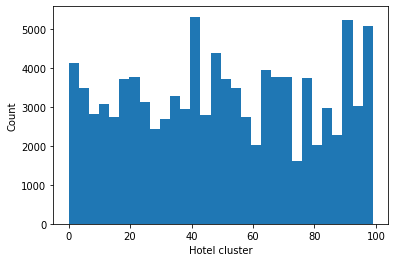

In [12]:
plt.hist(df_resampled_random['hotel_cluster'], bins=30)
plt.ylabel('Count')
plt.xlabel('Hotel cluster')

In [13]:
# Resample for equal class distributions
from sklearn.utils import resample

df_resampled_equal = pd.DataFrame()
class_size = 1000
#changed data_clean to df_clean 
classes = df_clean['hotel_cluster'].unique()

for c in classes:
    class_data = df_clean[df_clean.hotel_cluster == c]
    class_data_resampled = resample(class_data, replace=False, n_samples=class_size, random_state=42)    
    df_resampled_equal = pd.concat([df_resampled_equal, class_data_resampled])

print(df_resampled_equal.shape)

(100000, 24)


In [0]:
df_resampled_equal.to_csv('expedia_resampled_equal.csv', index=False)

In [15]:
# Drop unnecessary features

#df_dropped = df_resampled_random.copy()
df_dropped = df_resampled_equal.copy()

df_dropped = df_dropped.drop(['date_time'], axis=1)
df_dropped = df_dropped.drop(['user_id'], axis=1)
df_dropped = df_dropped.drop(['srch_ci'], axis=1)
df_dropped = df_dropped.drop(['srch_co'], axis=1)
df_dropped = df_dropped.drop(['site_name'], axis=1)

print(df_dropped.shape)
print(df_dropped.columns)

(100000, 19)
Index(['posa_continent', 'user_location_country', 'user_location_region',
       'user_location_city', 'orig_destination_distance', 'is_mobile',
       'is_package', 'channel', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster'],
      dtype='object')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


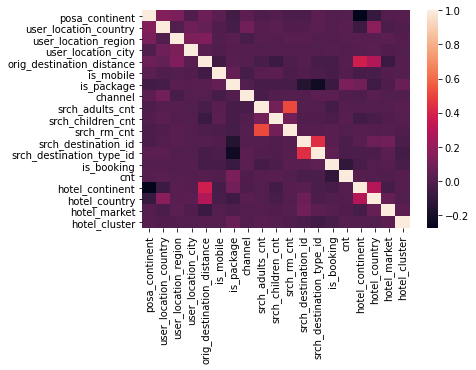

In [16]:
# Correlation heatmap
import seaborn as sns

corr = df_dropped.corr()
ax = sns.heatmap(corr)

In [17]:
# Get dummies for categorical features
data = pd.get_dummies(df_dropped)
print(data.shape)

(100000, 19)


In [0]:
# Test/train split
X = data.drop(['hotel_cluster'], axis=1)
Y = data['hotel_cluster']


In [19]:
# Select top K features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

n = 12
selector = SelectKBest(chi2, k=n)
X_new = selector.fit_transform(X, Y)

print(X_new.shape)

(100000, 12)


In [0]:
# Normal data
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

# Feature selection data
X_train, X_test, y_train, y_test = train_test_split(X_new, Y, test_size=0.25, random_state=42)


In [0]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, log_loss


def multiclass_roc_auc_score(y_test, y_pred):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred)

def evaluate(y_test, y_test_pred, y_prob):
    accuracy = accuracy_score(y_test, y_test_pred)
    print('Accuracy', accuracy)

    #auc = roc_auc_score(y_test, y_test_pred, average='macro', multi_class='ovr')
    auc = multiclass_roc_auc_score(y_test, y_test_pred)
    print('AUC', auc)

    loss = log_loss(y_test, y_prob)
    print('Cross Entropy Loss', loss)        

# Random Forest Model

In [26]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

rfc = RandomForestClassifier(n_estimators=23, random_state=42) #crashes when n_estimators > 23
rfc.fit(X_train,y_train)
rfc_pred = rfc.predict(X_test)
rfc_prob = rfc.predict_proba(X_test) 
evaluate(y_test, rfc_pred, rfc_prob)

print("\nClassification Report for total features\n")
print(classification_report(y_test, rfc_pred))

scores = cross_val_score(rfc, X_test, y_test)
print('Cross validation scores')
print(scores.mean())
print(scores)

Accuracy 0.1154
AUC 0.5539143885725041
Cross Entropy Loss 20.366065559769893

Classification Report for total features

              precision    recall  f1-score   support

           0       0.11      0.14      0.12       243
           1       0.28      0.30      0.29       248
           2       0.09      0.12      0.10       235
           3       0.05      0.05      0.05       263
           4       0.07      0.07      0.07       241
           5       0.03      0.04      0.03       252
           6       0.08      0.10      0.08       251
           7       0.07      0.09      0.08       255
           8       0.20      0.22      0.21       257
           9       0.06      0.07      0.06       244
          10       0.03      0.02      0.02       265
          11       0.06      0.06      0.06       262
          12       0.09      0.11      0.10       263
          13       0.06      0.07      0.06       258
          14       0.03      0.03      0.03       267
          15   

##Performance Report - Random Forest

RFC-Equal-TotalFeatures: Accuracy = 0.0954, AUC = 0.5449003310494316

RFC-Equal-12Features: Accuracy = 0.11636, AUC = 0.5543891633917712

RFC-Random-TotalFeatures: Accuracy = 0.0954, AUC = 0.5449003310494316

RFC-Random-12Features: Accuracy = 0.10088, AUC = 0.5482833226886301


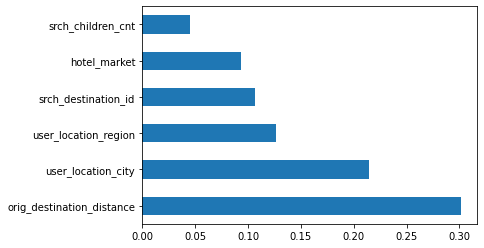

In [27]:
#Feature importance

#Normal dataset
#feature_importance = pd.Series(rfc.feature_importances_, index=X.columns)

#Reduced dataset
cols = selector.get_support(indices=True)
featureNames = X.iloc[:,cols]
feature_importance = pd.Series(rfc.feature_importances_, featureNames.columns)

#Plot bar graph - all features or nlargest
#feature_importance.plot(kind='barh')
feature_importance.nlargest(6).plot(kind='barh')

#MLP Classification

In [0]:
#MLP Classification
from keras.models import Sequential
from keras.layers import Dense
import time
import tensorflow as tf
from tensorflow.keras import layers
from sklearn import metrics

Using TensorFlow backend.


In [0]:
#Create the model
mlp = tf.keras.Sequential([                          
layers.Dense(128, activation='relu', input_shape=(12,)), #18 or 12 depending on feature selection
layers.Dropout(0.5),
layers.Dense(32, activation='relu'),
layers.Dropout(0.2),
layers.Dense(1, activation='softmax')])
mlp.summary()

#Binary classifier, group target labels
mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1664      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 5,825
Trainable params: 5,825
Non-trainable params: 0
_________________________________________________________________


In [0]:
mlp.fit(X_train,y_train,batch_size=100,epochs=10)

Epoch 1/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0100
Epoch 2/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0100
Epoch 3/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0100
Epoch 4/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0100
Epoch 5/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0100
Epoch 6/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0100
Epoch 7/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0100
Epoch 8/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0100
Epoch 9/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0100
Epoch 10/10
750/750 [==============================] - 1s 1ms/st

In [0]:
# MLP Model Performance
#Accuracy
performance = mlp.evaluate(X_test,y_test) 
print("%s: %.2f%%" % (mlp.metrics_names[1], performance[1]*100))

#AUC
y_pred = mlp.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
#print(f'AUC = {metrics.roc_auc_score(y_test, y_pred_bool):.2f}')
auc_score = multiclass_roc_auc_score(y_test, y_pred)
print('AUC', auc_score)

#F1
#print(classification_report(y_test,y_pred_bool))

782/782 [==============================] - 1s 951us/step - loss: 0.0000e+00 - accuracy: 0.0099
accuracy: 0.99%
391/391 [==============================] - 0s 892us/step
AUC 0.5


##Performance Notes - MLP

MLP-Random-TotalFeatures: Accuracy = 1.46%, AUC = 0.5

MLP-Random-12Features: Accuracy = 1.46%, AUC = 0.5

MLP-Equal-TotalFeatures: Accuracy = 0.99%, AUC = 0.5

MLP-Equal-12Features: Accuracy = 0.99%, AUC = 0.5 

---
Based on these results, the feature selection had no impact and while the MLP model using the randomized dataset had better accuracy, all the accuracy scores were horrible and all AUC were 0.5. **Conclusion: Change the model structure completely?** -> nothing worked!

---
Removing the Dropout layer resulted in less loss (from -48 to 0.69), but accuracy still bad (1.23%). AUC could not be caluclated.

---
Removing second dense layer and adding back dropout layer resulted in same scores as original model

---
Altering learning rate (.001, .01), size of Dense layers (128 to 256, etc), optimizers (Adam,Adagrad,RMSProp,SGD) did absolutely nothing